In [1]:
from datasets import load_dataset, Audio
from pathlib import Path

c:\Users\sebas\mambaforge\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
dataset = load_dataset("audiofolder", data_dir="../WakeWordDetection/EfficientWord-Net/dataset_format_fixed")

Resolving data files: 100%|██████████| 13412/13412 [00:01<00:00, 10279.63it/s]
Found cached dataset audiofolder (D:/hf_datasets/audiofolder/default-a1fcb3e21f1bd03a/0.0.0/6cbdd16f8688354c63b4e2a36e1585d05de285023ee6443ffd71c4182055c0fc)
100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


In [12]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))['train']

In [17]:
import torch
train_data = dataset.select(torch.argwhere(dataset['label'] < 2425))
test_data = dataset.select(torch.argwhere(dataset['label'] >= 2425))

In [44]:
dataset.select([1])[0]['audio']['array'].shape

(24600,)

In [54]:
np.trim_zeros(dataset.select([1])[0]['audio']['array']).dtype

dtype('float64')

In [55]:
np.trim_zeros(dataset.select([1])[0]['audio']['array']).shape

(13212,)

In [56]:
np.trim_zeros(dataset.select([1])[0]['audio']['array'].astype(np.float16)).shape

(12710,)

In [59]:
np.trim_zeros(dataset.select([1])[0]['audio']['array']).astype(np.float32).shape

(13212,)

In [65]:
import numpy as np
def trim_zeros(example):
    audio = example['audio']['array'] 
    return {"samples": np.trim_zeros(audio).astype(np.float32)} #! Coding it back to audio is very slow.

dataset_map = dataset.map(trim_zeros, remove_columns=['audio'])

In [66]:
dataset_map[0]

{'label': 0,
 'samples': [-1.0913936421275139e-11,
  -3.637978807091713e-12,
  -5.4569682106375694e-12,
  -7.275957614183426e-12,
  -7.275957614183426e-12,
  -1.000444171950221e-11,
  -7.275957614183426e-12,
  -1.8189894035458565e-11,
  -5.002220859751105e-12,
  -1.1823431123048067e-11,
  -9.094947017729282e-12,
  -1.1823431123048067e-11,
  -7.275957614183426e-12,
  -1.4551915228366852e-11,
  0.0,
  -2.1827872842550278e-11,
  0.0,
  -1.0913936421275139e-11,
  7.275957614183426e-12,
  -5.4569682106375694e-12,
  -5.4569682106375694e-12,
  -1.2732925824820995e-11,
  3.637978807091713e-12,
  0.0,
  5.4569682106375694e-12,
  -7.275957614183426e-12,
  -3.637978807091713e-12,
  3.637978807091713e-12,
  0.0,
  -7.275957614183426e-12,
  1.0913936421275139e-11,
  -7.275957614183426e-12,
  1.8189894035458565e-12,
  -9.094947017729282e-13,
  6.366462912410498e-12,
  5.4569682106375694e-12,
  9.094947017729282e-13,
  7.275957614183426e-12,
  9.094947017729282e-12,
  1.2278178473934531e-11,
  1.2732

In [19]:
train_data['label'][-1]

tensor(2424)

In [21]:
test_data['label'][0]

tensor(2425)

In [21]:
dataset = dataset.with_format("torch")

In [7]:
dataset_split['train']['label'][-1]

tensor(2424)

In [9]:
dataset_split['test']['label'][0]

tensor(2424)

In [5]:
noise = load_dataset("audiofolder", data_dir="../WakeWordDetection/EfficientWord-Net/noise_files_format_fixed")

Found cached dataset audiofolder (D:/hf_datasets/audiofolder/default-1861a7a69e6f4acc/0.0.0/6cbdd16f8688354c63b4e2a36e1585d05de285023ee6443ffd71c4182055c0fc)
100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


In [6]:
noise = noise.cast_column("audio", Audio(sampling_rate=16000))

In [7]:
noise_sample = noise['train'].select([0])

In [8]:
def get_chunked_audio(example):
    audio = example['audio'][0]
    waveform = audio['array']
    sr = audio["sampling_rate"]
    path = Path(audio['path']).parts

    chunks = []
    for i in range(0, len(waveform), sr):
        chunks.append({
            "path": f"{path[-2]}_{path[-1][:-4]}_{i//sr}",
            'array': waveform[i:i+sr],
            "sampling_rate": sr,
        })

    return {"audio": chunks}

In [14]:
# One must use batched=True if one wants to return many examples 
noise = noise.map(get_chunked_audio, remove_columns=["label", 'audio'], batched=True, batch_size=1)

In [21]:
noise = noise.with_format("torch")

In [33]:
import numpy as np
import random

def _fix_padding_issues(x, length=16000):
    x = np.trim_zeros(x)
    
    n_samples = len(x)
    if n_samples > length:
        frontBits = random.randint(0, n_samples - length)
        return x[frontBits : frontBits + length]
    
    needed_pad = length - n_samples
    pad_left = random.randint(0, needed_pad)
    pad_right = needed_pad - pad_left
    
    return np.pad(x, (pad_left, pad_right), 'constant')
    

array([ 0.28693625, -0.69164205,  0.41764134, ...,  0.2591397 ,
       -0.59713761,  0.        ])

In [63]:
a,b = np.random.uniform(0,1,2)

In [64]:
a

0.9874929848052693

In [65]:
b

0.3068302806379012

In [2]:
import torch

def _weird_loss(self, y_true, y_pred):
    # They define some weird kind of BCE loss based on distances
    # Here they opt definitelly for Euclidean distance
    match_loss = y_true * -2.0 * torch.log(1 - y_pred / 2)
    mismatch_loss = torch.maximum(
        (1 - y_true) * (-torch.log(y_pred / 0.2)), torch.zeros_like(y_true)
    )

    return torch.mean(match_loss + mismatch_loss)

In [4]:
t = torch.tensor([1.0,1.0,1.0,1.0,1.0,1.0])
q = t - 0

print(_weird_loss(0,t,q))

tensor(1.3863)


In [6]:
import numpy as np

In [38]:
wanted_spec = np.load("aberdeen_moira_siri.npy")
wanted_spec.T

array([[-6.8524003, -6.8312345, -6.760754 , ..., -7.0166855, -7.0166855,
        -7.0166855],
       [-6.8607497, -6.748418 , -6.5920963, ..., -7.0166855, -7.0166855,
        -7.0166855],
       [-6.890926 , -6.532188 , -6.4737306, ..., -7.0166855, -7.0166855,
        -7.0166855],
       ...,
       [-6.8942533, -6.6170583, -6.6668024, ..., -7.0166855, -7.0166855,
        -7.0166855],
       [-6.922771 , -6.7769475, -6.754378 , ..., -7.0166855, -7.0166855,
        -7.0166855],
       [-7.0043736, -6.9734926, -6.9852576, ..., -7.0166855, -7.0166855,
        -7.0166855]], dtype=float32)

In [32]:
audio_to_match = dataset[3]['audio']['array']

In [41]:
audio_to_match.mean()

tensor(3.8193e-05)

In [54]:
import librosa
import matplotlib.pyplot as plt
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", to_db=False):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    specgram = librosa.power_to_db(specgram) if to_db else specgram
    print(specgram.mean(), specgram.std())
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [55]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

-3.4455762 2.4723208


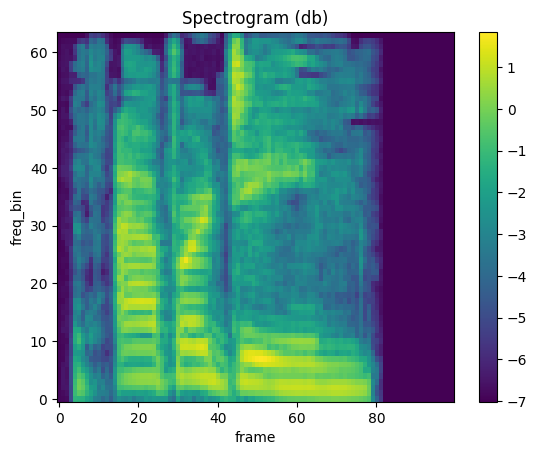

In [56]:
plot_spectrogram(wanted_spec.T)


tensor(0.0352) tensor(0.1893)


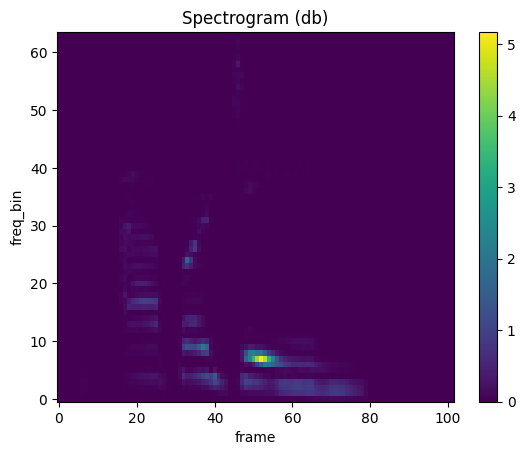

In [60]:
spec1 = MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160,f_min=50, f_max=8000, n_mels=64, normalized=True)(audio_to_match)
plot_spectrogram(spec1, to_db=False)

-25.30852 22.017735


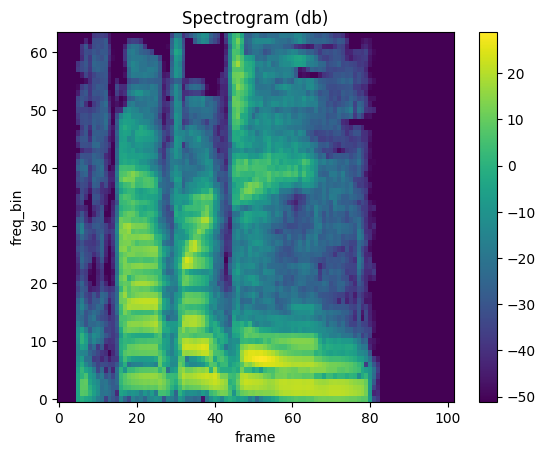

In [58]:
spec2= MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160,f_min=50, f_max=8000, n_mels=64)(audio_to_match)
plot_spectrogram(spec2, to_db=True)

tensor(-25.3085) tensor(22.0194)


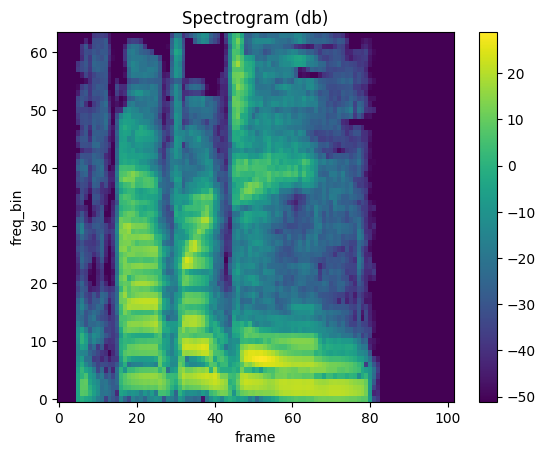

In [61]:
spec3 = AmplitudeToDB(top_db=80)(MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160,f_min=50, f_max=8000, n_mels=64)(audio_to_match))
plot_spectrogram(spec3, to_db=False)

tensor(-22.5579) tensor(18.5975)


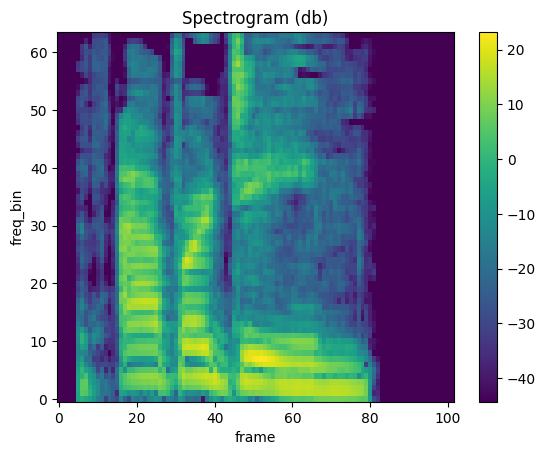

In [62]:
spec3 = AmplitudeToDB(top_db=80)(MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160,f_min=50, f_max=8000, n_mels=64)(audio_to_match))
LOG_MEL_MEAN = 1.4
LOG_MEL_STD = 1.184
plot_spectrogram((spec3-LOG_MEL_MEAN) / LOG_MEL_STD, to_db=False)

tensor(-2.9218e-09) tensor(1.)


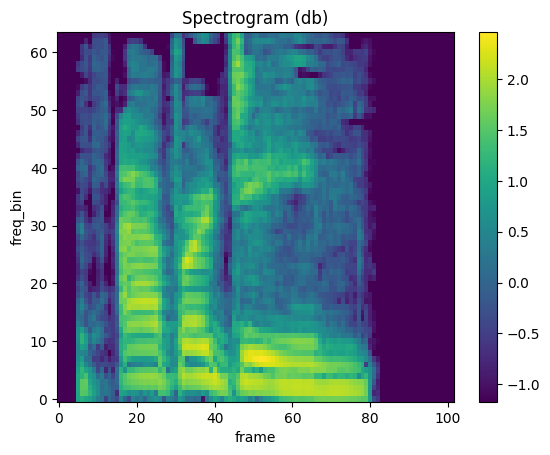

In [63]:
spec3 = AmplitudeToDB(top_db=80)(MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160,f_min=50, f_max=8000, n_mels=64)(audio_to_match))
m = spec3.mean()
s = spec3.std()
plot_spectrogram((spec3-m) / s, to_db=False)

In [70]:
torch.randn(1,32,102,64).mean(dim=(0,2,3)).shape

torch.Size([32])

In [ ]:
import pytorch_lightning as L
class NewSota:
    pass

class DataToBeCrashed(L.LightningDataModule):
    """Implement dataset to be destroyed"""

class ART:
    @classmethod
    def train(cls, config):
        pass

In [ ]:
config = {
    "baseline": None,
    "TrainingViz": None,
    "datamodule": NewSota,
    "model": DataToBeCrashed,
    "logger": "neptune"
}

ART.train(config)